# Instructions: 
##### To just produce final graph(s) as seen in the paper, run cells in "Section 1: Setup" and "Section 2: Final Graph(s)" section only, ignore the "Section 3: Simulations "
##### To run the simulations and produce your own data, run the whole notebook

In [3]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.linalg
import matplotlib
import csv
import random
from itertools import groupby
import collections

def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

plt.style.use('seaborn-talk')
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10

def migration_matrix(length, migration_rate):
    first_col = np.zeros(length)
    first_col[1] = migration_rate
    first_col[-1] = migration_rate
    result = scipy.linalg.circulant(first_col)
    return result

Deme_density = 50
L = 1000 #the number of demes 
deme_sample_size = Deme_density #deme sample size 
trials = 50 #number of trials
m = 0.2 #migration rate
total_sample_size = L * deme_sample_size # total sample size
matrix = migration_matrix(L, m/2)
total_population_size=L * Deme_density

population_configurations = L * [msprime.PopulationConfiguration(sample_size=deme_sample_size)]

print("we want 1 <<< m*deme_density <<< number of demes to keep continous structure")
print("1 <<< ",m*Deme_density," <<< ",L )


we want 1 <<< m*deme_density <<< number of demes to keep continous structure
1 <<<  10.0  <<<  1000


### Section 2: Simulations

### Function that splits list (needed for larger populations)


In [4]:
def split_list(alist, wanted_parts):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]
leaf_list=[[0]]
for i in range (1,total_sample_size):
    leaf_list.append([i])
wanted_parts=int(deme_sample_size/4)
split_leaf_list=split_list(leaf_list,wanted_parts)
a=[ [0]*int(total_sample_size+1) for i in range(2*total_sample_size-1)]

In [5]:
print(migration_matrix(5,1))

[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]


In [6]:
transition_freq=(max(Deme_density,(m*Deme_density**2)))
print("transition count = ", transition_freq)

transition count =  500.0


In [7]:
min_transition_zone=transition_freq # transition frequency formula
max_transition_zone=0.2*total_sample_size
diff=max_transition_zone-min_transition_zone
print()
x=np.linspace(min_transition_zone,max_transition_zone,10)


In [8]:
for i in range(len(x)):
    print(int(x[i]))

500
1555
2611
3666
4722
5777
6833
7888
8944
10000


In [9]:
transition_freq

500.0

In [10]:
Deme_density 

50

### Simulations populaton structure over a number of trials and averages out the number of descendants in each trial into an array "b"

iteration 0


The provenance information for the resulting tree sequence is 4.90MB. This is nothing to worry about as provenance is a good thing to have, but if you want to save this memory/storage space you can disable provenance recording by setting record_provenance=False


[208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401]


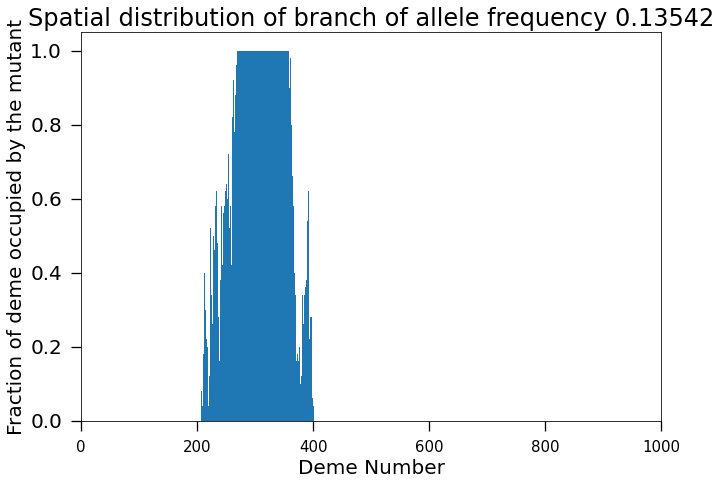

<Figure size 748.8x514.8 with 0 Axes>

[720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 928, 929, 930, 931,

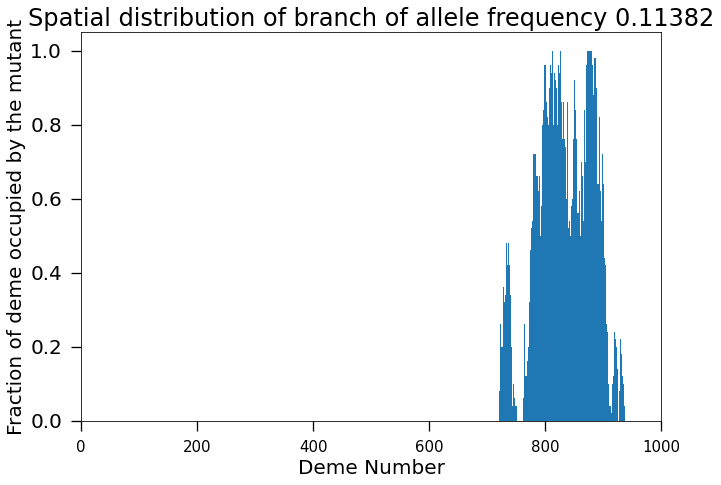

<Figure size 748.8x514.8 with 0 Axes>

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

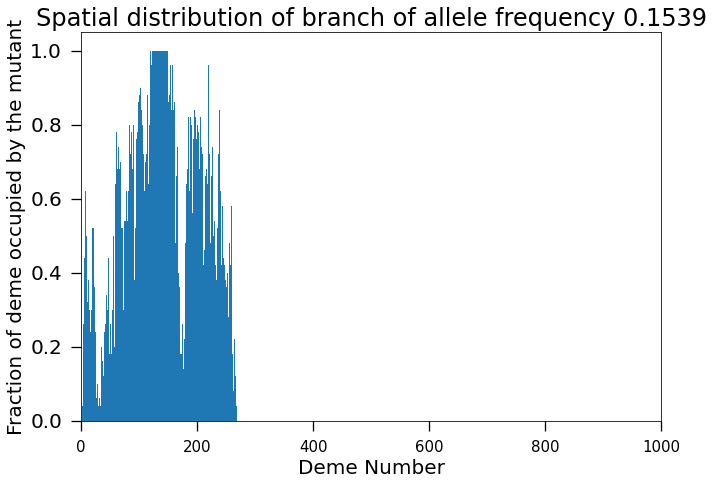

<Figure size 748.8x514.8 with 0 Axes>

[720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929,

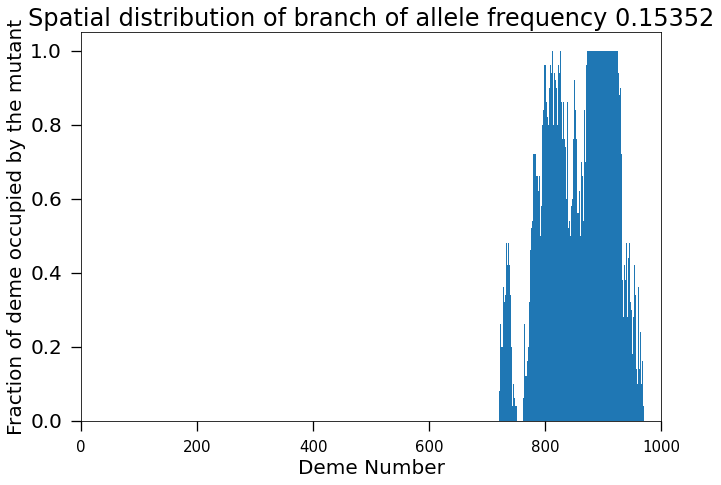

<Figure size 748.8x514.8 with 0 Axes>

[512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 544, 546, 547, 548, 549, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511]


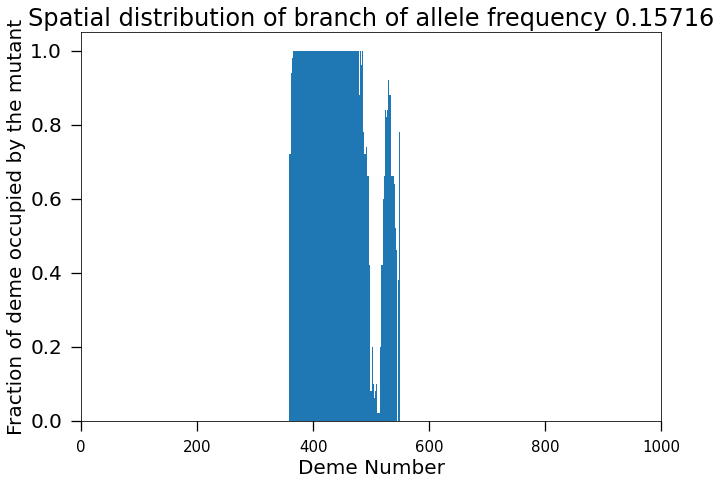

<Figure size 748.8x514.8 with 0 Axes>

[515, 516, 519, 520, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 686]


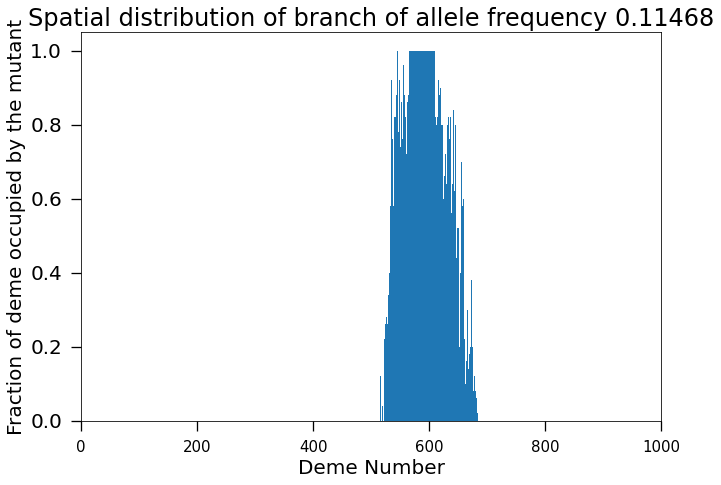

<Figure size 748.8x514.8 with 0 Axes>

[536, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,

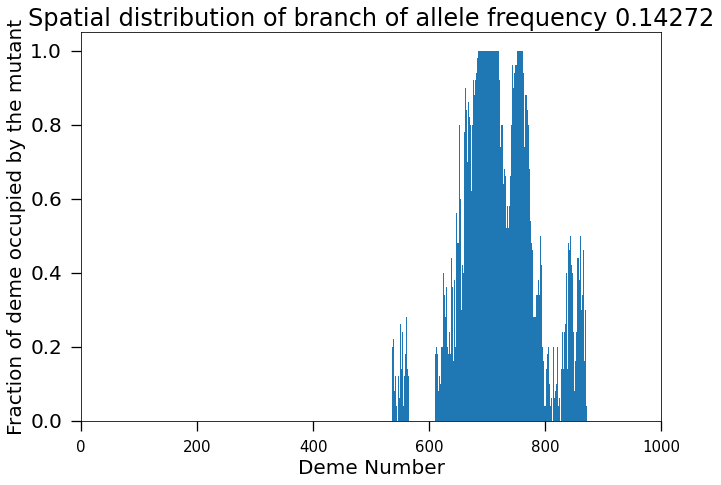

<Figure size 748.8x514.8 with 0 Axes>

In [11]:
allele_frequency_vals=[]
q=[ [0]*int(total_sample_size+1) for i in range(2*total_sample_size-1)]
afs2 = []
#a2=[]
for i in range(1):
    print("iteration",i)
    ts = msprime.simulate(Ne=Deme_density, population_configurations=population_configurations, migration_matrix=matrix)
   
    a=ts.mean_descendants(leaf_list) #Finds the descendants for each trial and sums them up

    afs1 = ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
    
    afs2.append(afs1)
  

        
    #transition zone
    num_desc  = a.sum(axis=1)
    #print(num_desc)
    index_vals=[]
    count_vals=[]
    min_transition_zone=0.10*total_sample_size# transition frequency formula
    max_transition_zone=0.19*total_sample_size
    for j in range(len(num_desc)):
        if min_transition_zone<num_desc[j]<max_transition_zone:
            index_vals.append(j)
            count_vals.append(num_desc[j])
    #print(count_vals)        
    ######
    
    transition_desc=[]

    for i in range(len(index_vals)):
        transition_desc.append(a[int(index_vals[i])])
    #print(transition_desc)
    #print(len(transition_desc[0]))
    #print(len(transition_desc[1]))
    #np.savetxt("transition_zone_desc.csv", transition_desc , delimiter=",")
    
    ######
    
    spatial_transition = [ []*1 for i in range(len(transition_desc))]
    for i in range(len(transition_desc)):
        for j in range(len(transition_desc[i])):
            if transition_desc[i][j]>0:
                spatial_transition[i].append(j)


    #np.savetxt("spatial_transition.csv", spatial_transition ,fmt="%s", delimiter=",")
    
    ######
    
    demes=spatial_transition
    for i in range(len(demes)):
        for j in range(len(demes[i])):
            demes[i][j]=demes[i][j]//50 # divides and rounds down to allocate into demes (0-1000)
  

    #np.savetxt("demes_t.csv", demes ,fmt="%s", delimiter=",")
    
    
    ######
    
    #print(len(demes))
    freq=np.array(count_vals)
    #print(count_vals)
    #print(freq)
    freq=freq/(total_sample_size)
    
    #print("frequency")
    #print(freq)
    
    #print("count_vals")
    #print(count_vals)
    
    dist=np.linspace(0,len(demes)-1,len(demes))
    #print(dist)

    #print(demes)
    #print(len(demes))
    ######
    base_width=[0]
    frequency=[0]
    for i in range(len(dist)):
        counter=collections.Counter(demes[int(dist[i])])
        z=list(counter.values())
        z_new= [v/50 for v in z]
        x=get_unique_numbers(demes[int(dist[i])])
        #print(z)
        print(x)
        #base_width.append(len(x))
        frequency.append(freq[int(dist[i])])
        #plt.bar(x,z, width=1.0)
        plt.bar(x,z_new,width=1.0)
        plt.xlim(0,1000)
        plt.xlabel("Deme Number")
        plt.ylabel("Fraction of deme occupied by the mutant",)
        np.savetxt("Demes_Mrhogreat"+ str(i) +".csv",x, delimiter=',' )
        np.savetxt("Demes_Fraction_Mrhogreat"+ str(i) +".csv",z, delimiter=',' )
        plt.title("Spatial distribution of branch of allele frequency " + str(freq[int(dist[i])]))
        allele_frequency_vals.append(freq[int(dist[i])])
        
        
        plt.figure()
        
        plt.show()


  
    

#b=np.mean(a2,0)

#b=a/trials #Divides the sum of the  descendants by the number of trials to find the expected number of descendants per node
  
    

#b=np.mean(a2,0)

#b=a/trials #Divides the sum of the  descendants by the number of trials to find the expected number of descendants per node


### Section 3: Graphs

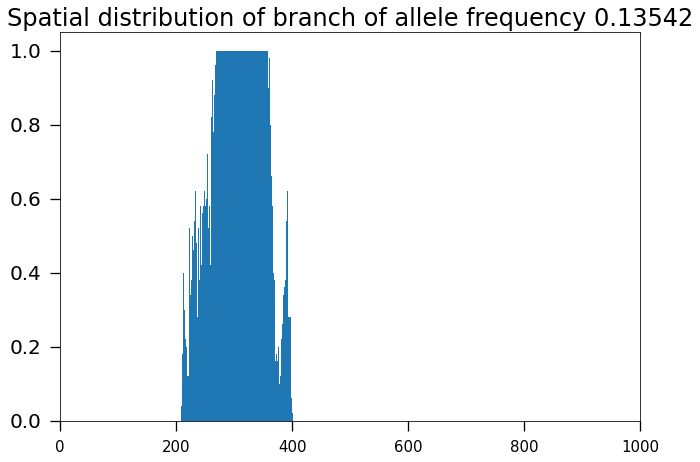

<Figure size 748.8x514.8 with 0 Axes>

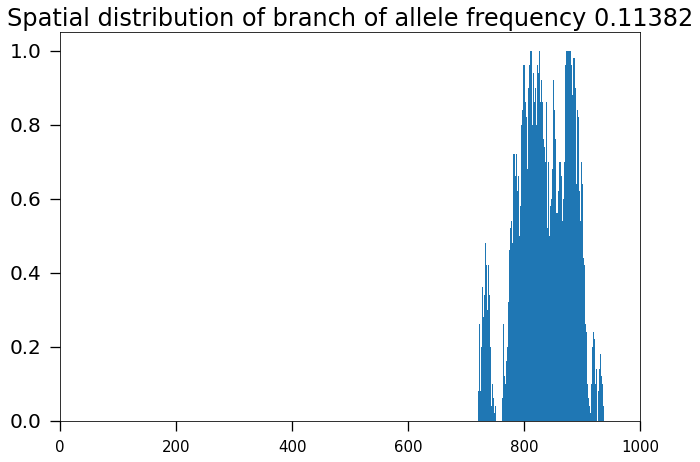

<Figure size 748.8x514.8 with 0 Axes>

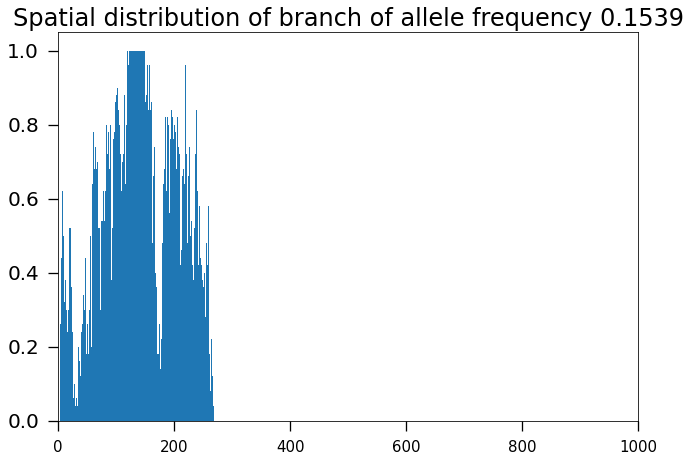

<Figure size 748.8x514.8 with 0 Axes>

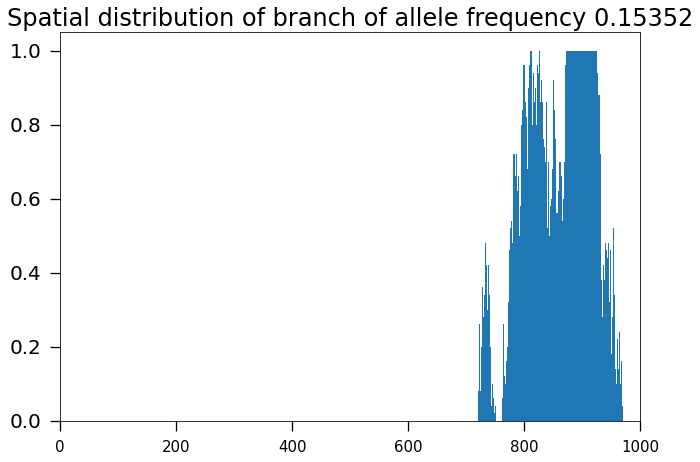

<Figure size 748.8x514.8 with 0 Axes>

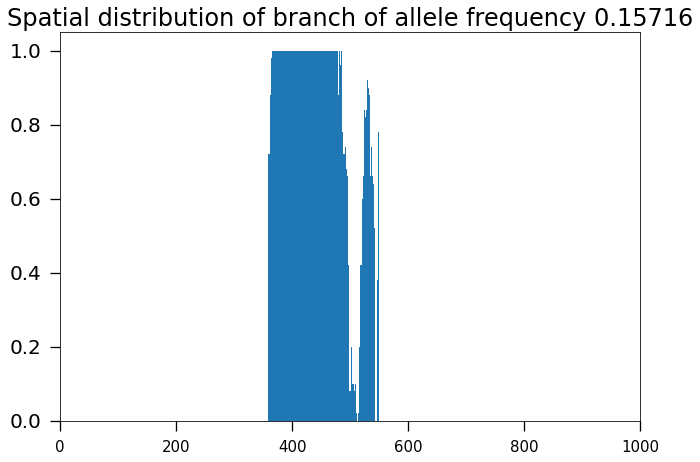

<Figure size 748.8x514.8 with 0 Axes>

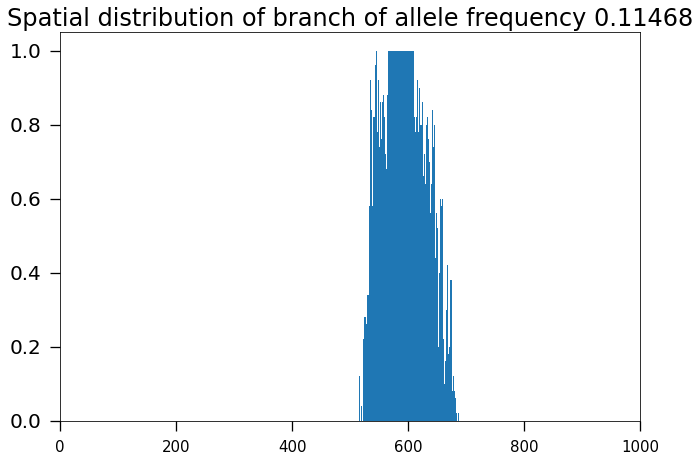

<Figure size 748.8x514.8 with 0 Axes>

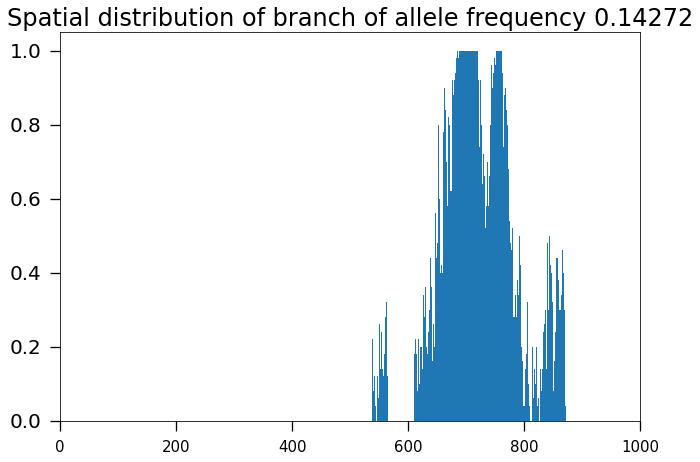

<Figure size 748.8x514.8 with 0 Axes>

In [12]:
for i in range(len(dist)): ##replace 10 with len(dist) if you are running your own simulations
    x=np.array(+ str(i) +'.csv'))
    y=np.array(pd.read_csv('Demes_Fraction_Mrhogreat'+str(i)+'.csv'))
    Deme_Number=x.flatten()
    Fraction=y.flatten()/Deme_density
    plt.bar(Deme_Number, Fraction, width=1.0)
    plt.xlim(0,1000)
    plt.title("Spatial distribution of branch of allele frequency " + str(allele_frequency_vals[i]))
    plt.savefig("mrhogreat"+ str(i) + ".pdf")
    plt.figure()
    plt.show()